<h1>Data Investigation and Training</h1>
<p>Investigate our data and Train our predictive model using AutoML</p>

In [29]:
import joblib
import pandas as pd
from flaml import AutoML, tune
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [30]:
df = pd.read_excel("../data/Real_estate_valuation_dataset.xlsx")
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [31]:
new_col_names = {"No":"id",
                 "X1 transaction date":"transaction_date",
                 "X2 house age":"house_age",
                 "X3 distance to the nearest MRT station":"dist_to_nearest_mrt_station",
                 "X4 number of convenience stores":"number_of_convenience_stores",
                 "X5 latitude":"latitude",
                 "X6 longitude":"longitude",
                 "Y house price of unit area":"price_of_unit_area"
                 }

target_col = "price_of_unit_area"

df.rename(columns=new_col_names,inplace=True)

In [32]:
df.dtypes

id                                int64
transaction_date                float64
house_age                       float64
dist_to_nearest_mrt_station     float64
number_of_convenience_stores      int64
latitude                        float64
longitude                       float64
price_of_unit_area              float64
dtype: object

In [33]:
df.shape

(414, 8)

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,414.0,207.500000,119.655756,1.000000,104.250000,207.500000,310.750000,414.000000
transaction_date,414.0,2013.148953,0.281995,2012.666667,2012.916667,2013.166667,2013.416667,2013.583333
house_age,414.0,17.712560,11.392485,0.000000,9.025000,16.100000,28.150000,43.800000
dist_to_nearest_mrt_station,414.0,1083.885689,1262.109595,23.382840,289.324800,492.231300,1454.279000,6488.021000
number_of_convenience_stores,414.0,4.094203,2.945562,0.000000,1.000000,4.000000,6.000000,10.000000
latitude,414.0,24.969030,0.012410,24.932070,24.963000,24.971100,24.977455,25.014590
longitude,414.0,121.533361,0.015347,121.473530,121.528085,121.538630,121.543305,121.566270
price_of_unit_area,414.0,37.980193,13.606488,7.600000,27.700000,38.450000,46.600000,117.500000


In [35]:
df.isnull().sum()

id                              0
transaction_date                0
house_age                       0
dist_to_nearest_mrt_station     0
number_of_convenience_stores    0
latitude                        0
longitude                       0
price_of_unit_area              0
dtype: int64

In [36]:
abs(df.corr())[target_col].sort_values(ascending=False)[1:]

dist_to_nearest_mrt_station     0.673613
number_of_convenience_stores    0.571005
latitude                        0.546307
longitude                       0.523287
house_age                       0.210567
transaction_date                0.087529
id                              0.028587
Name: price_of_unit_area, dtype: float64

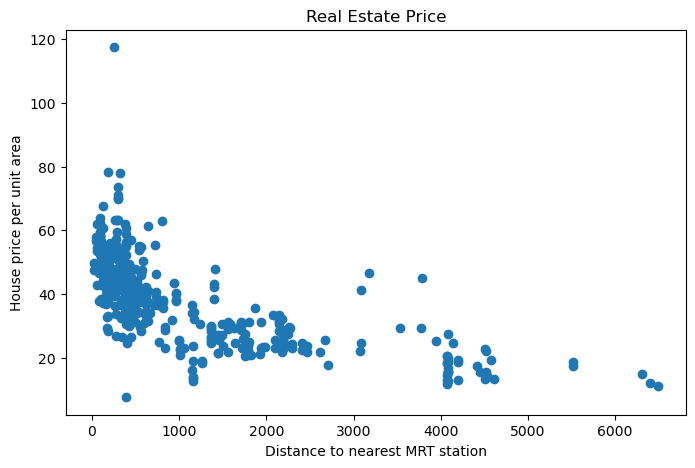

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
plt.scatter(x=df['dist_to_nearest_mrt_station'], y=df[target_col])
plt.xlabel('Distance to nearest MRT station')
plt.ylabel('House price per unit area')
plt.title('Real Estate Price')
plt.show()

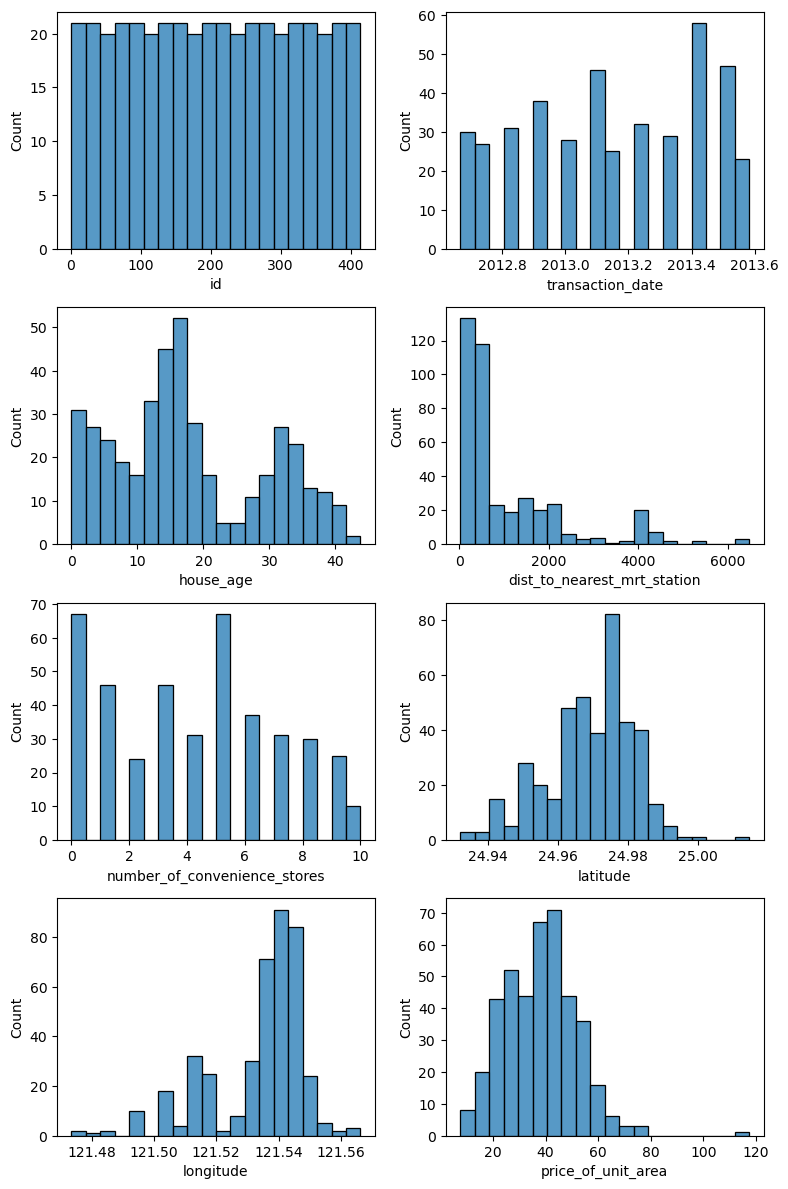

In [38]:
nb_rows = 4
nb_cols = 2

fig, axs = plt.subplots(nb_rows, nb_cols, figsize = (4 * nb_cols, 3 * nb_rows))
for i in range(nb_rows):
    for j in range(nb_cols):
        _ = sns.histplot(data=df, x=df.columns[nb_cols * i + j], ax=axs[i,j], bins=20)
        
fig.tight_layout()

In [41]:
## Let's have a look at the data on a map :)
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from branca.colormap import linear

def display_clustered_map(df, lat_col, lon_col, price_col):
    # transform DataFrame as GeoDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]))

    price_colormap = linear.YlOrRd_04.scale(
        gdf[price_col].min(), gdf[price_col].max()
    )

    m = folium.Map(location=[gdf[lat_col].mean(), gdf[lon_col].mean()], zoom_start=13)

    # Add markers with colors
    marker_cluster = MarkerCluster().add_to(m)
    for _, row in gdf.iterrows():
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=5,
            color=price_colormap(row[price_col]),
            fill=True,
            fill_color=price_colormap(row[price_col]),
        ).add_to(marker_cluster)

    price_colormap.add_to(m)
    return m

# map.save('prices_mapping.html') 

def display_geo_datapoints(df, lat_col, lon_col, price_col):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]))
    price_colormap = linear.YlOrRd_04.scale(gdf[price_col].min(), gdf[price_col].max())
    m = folium.Map(location=[gdf[lat_col].mean(), gdf[lon_col].mean()], zoom_start=12,tiles='CartoDB positron')
    for _, row in gdf.iterrows():
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=5,
            color=price_colormap(row[price_col]),
            fill=True,
            fill_color=price_colormap(row[price_col]),
        ).add_to(m)

    price_colormap.add_to(m)
    return m 


In [42]:
display_geo_datapoints(df, 'latitude', 'longitude', target_col)

In [43]:
display_clustered_map(df, 'latitude', 'longitude', target_col)

In [44]:
X = df.drop([target_col,'id'],axis=1)
y = df[[target_col]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=101)

In [45]:
X.head()

,transaction_date,house_age,dist_to_nearest_mrt_station,number_of_convenience_stores,latitude,longitude
0,2012.916667,32.0,84.87882,10,24.98298,121.54024
1,2012.916667,19.5,306.59470,9,24.98034,121.53951
2,2013.583333,13.3,561.98450,5,24.98746,121.54391
3,2013.500000,13.3,561.98450,5,24.98746,121.54391
4,2012.833333,5.0,390.56840,5,24.97937,121.54245


In [46]:
import logging
import numpy as np
from flaml import logger
logger.setLevel(logging.WARNING)

In [47]:
automl = AutoML()
automl_settings = {
    "time_budget": 10 * 60,  # max running time
    "metric": 'mse', 
    "task": 'regression',  
    "estimator_list":['lgbm', 'rf','extra_tree', 'xgboost', 'xgb_limitdepth'],
    "log_file_name": 'prices.log',
    "log_training_metric": True,  
    "keep_search_state": True, 
    "eval_method": "cv",
    "split_type": "auto",
    "n_splits": 4,
    "ensemble":True, #let's get crazy :)
    "log_type":'all'
}

automl_settings['custom_hp'] = {}

for estimator in ['lgbm', 'xgboost', 'xgb_limitdepth']:
    automl_settings['custom_hp'][estimator] = {
        "scale_pos_weight":{
            "domain": tune.loguniform(lower = 1., upper = 10., base = np.exp(1)),
            "init_value": 1.0
        }
    }
    
for estimator in ['rf', 'extra_tree']:
    automl_settings['custom_hp'][estimator] = {}


_ = automl.fit(X_train.to_numpy(), y_train.to_numpy(), **automl_settings)

[flaml.automl.logger: 11-02 21:25:04] {1679} INFO - task = regression
[flaml.automl.logger: 11-02 21:25:04] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 11-02 21:25:04] {1788} INFO - Minimizing error metric: mse
[flaml.automl.logger: 11-02 21:25:04] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'extra_tree', 'xgboost', 'xgb_limitdepth']
[flaml.automl.logger: 11-02 21:25:04] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-02 21:25:04] {2344} INFO - Estimated sufficient time budget=515s. Estimated necessary time budget=4s.
[flaml.automl.logger: 11-02 21:25:04] {2391} INFO -  at 0.1s,	estimator lgbm's best error=136.1676,	best estimator lgbm's best error=136.1676
[flaml.automl.logger: 11-02 21:25:04] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-02 21:25:04] {2391} INFO -  at 0.1s,	estimator lgbm's best error=136.1676,	best estimator lgbm's best error=136.1676
[flaml.automl.logger: 11-02 21:25:04] {2218} IN

In [48]:
(1-pd.Series(automl.best_loss_per_estimator)).sort_values(ascending=False).round(5)

lgbm             -60.05409
rf               -61.19556
xgboost          -61.75502
xgb_limitdepth   -61.90088
extra_tree       -71.34295
dtype: float64

In [49]:
print('Best hyperparmeter config:', automl.best_config)
print('Best metric on validation data: {0:.5g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.2g} s'.format(automl.best_config_train_time))


Best hyperparmeter config: {'n_estimators': 4, 'num_leaves': 33, 'min_child_samples': 7, 'learning_rate': 1.0, 'log_max_bin': 5, 'colsample_bytree': 0.9698804366524494, 'reg_alpha': 0.013322404115446386, 'reg_lambda': 25.45366423083293, 'scale_pos_weight': 1.060292472035592}
Best metric on validation data: -60.054
Training duration of best run: 0.016 s


In [50]:
automl.model

StackingRegressor(estimators=[('lgbm',
                               <flaml.automl.model.LGBMEstimator object at 0x17d362350>),
                              ('rf',
                               <flaml.automl.model.RandomForestEstimator object at 0x17d528410>),
                              ('xgboost',
                               <flaml.automl.model.XGBoostSklearnEstimator object at 0x17d52b6d0>),
                              ('xgb_limitdepth',
                               <flaml.automl.model.XGBoostLimitDepthEstimator object at 0x17d40b5d0>),
                              ('extra_tree',
                               <flaml.automl.model.ExtraTreesEstimator object at 0x17d57fa90>)],
                  n_jobs=1, passthrough=True)

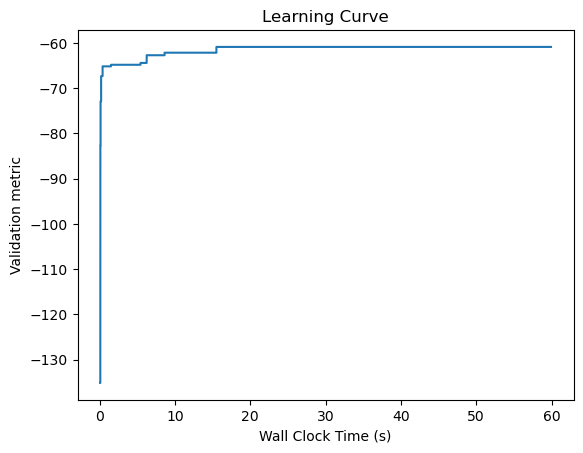

In [51]:
from flaml.automl.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename=automl_settings['log_file_name'], time_budget=60)
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation metric')
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [52]:
import pickle
with open('../model/automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [53]:
col_names = list(X.columns) 
joblib.dump(col_names, '../model/model_columns.pkl')
col_names

['transaction_date',
 'house_age',
 'dist_to_nearest_mrt_station',
 'number_of_convenience_stores',
 'latitude',
 'longitude']

In [54]:
automl_inference = pickle.load(open('../model/automl.pkl', 'rb'))
y_pred = automl_inference.predict(X_test.to_numpy())

In [55]:
preds = pd.Series(y_pred,name="preds")

In [56]:
df_test = X_test.merge(preds,left_index=True, right_index=True)
df_test = df_test.merge(y_test,left_index=True, right_index=True)

In [57]:
df_test['residuals'] = df_test[target_col] - df_test['preds']
df_test['abs_residuals'] = df_test['residuals'].apply(lambda x: abs(x))

In [58]:
df_test

,transaction_date,house_age,dist_to_nearest_mrt_station,number_of_convenience_stores,latitude,longitude,preds,price_of_unit_area,residuals,abs_residuals
38,2012.666667,3.1,577.96150,6,24.97201,121.54722,18.492152,47.7,29.207848,29.207848
19,2012.666667,1.5,23.38284,7,24.96772,121.54102,44.386490,47.7,3.313510,3.313510
72,2013.583333,32.5,424.54420,8,24.97587,121.53913,30.513079,36.3,5.786921,5.786921
8,2013.500000,31.7,5512.03800,1,24.95095,121.48458,49.496900,18.8,-30.696900,30.696900
43,2012.750000,34.4,512.78710,6,24.98748,121.54301,52.567908,34.1,-18.467908,18.467908
81,2013.000000,30.8,377.79560,6,24.96427,121.53964,39.960550,36.8,-3.160550,3.160550
53,2013.083333,13.3,492.23130,5,24.96515,121.53737,20.834033,38.9,18.065967,18.065967
56,2013.416667,33.6,371.24950,8,24.97254,121.54059,46.531576,41.9,-4.631576,4.631576
51,2013.083333,31.3,1758.40600,1,24.95402,121.55282,35.147543,20.7,-14.447543,14.447543
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,26.418024,43.1,16.681976,16.681976


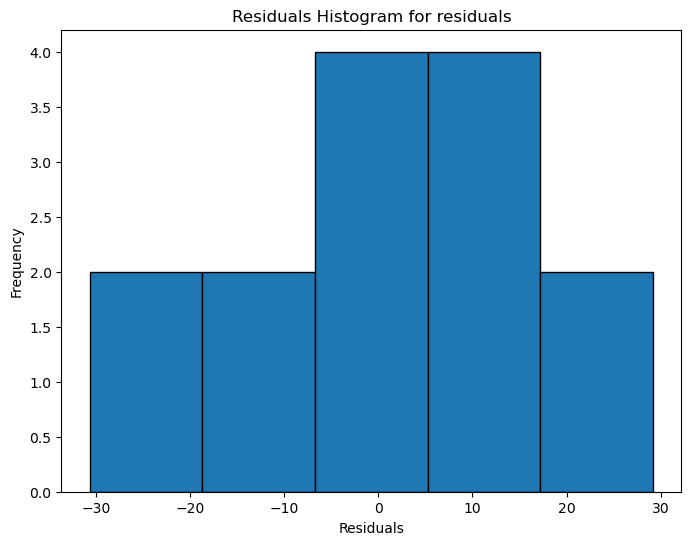

In [59]:
plt.figure(figsize=(8, 6))
plt.hist(df_test["residuals"], bins=5, edgecolor='k')
plt.title(f'Residuals Histogram for residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [61]:
display_geo_datapoints(df_test, 'latitude', 'longitude', "residuals")

<h2>Let's test if we send a json to the model</h2>

In [86]:
r=[{'transaction_date':2013.9123,
 'house_age':17,
 'dist_to_nearest_mrt_station':837.7233,
 'number_of_convenience_stores':10,
 'latitude':24.96334,
 'longitude':121.54767}]

In [89]:
pd.DataFrame(r).reindex(columns=col_names).dtypes

transaction_date                float64
house_age                         int64
dist_to_nearest_mrt_station     float64
number_of_convenience_stores      int64
latitude                        float64
longitude                       float64
dtype: object

In [100]:
automl_inference.predict(pd.DataFrame(r).reindex(columns=col_names).to_numpy())[0]

37.11286492371255